In [53]:
import math

In [54]:


class Value:
    def __init__(self, data, _children = (), _op='', label='', grad = 0.0):
        self.data = data
        self._prev = set(_children) # used to store which Values were used to get this data
        self._op = _op # which operation was run on the children Values to get this data
        self.label = label # what should it be known as in the graph vis (just the var name usually)
        self.grad = grad # what is the gradient wrt to the final root node

    def __repr__(self):
        return f"Value (data = {self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


    def tanh(self):
        x = self.data
        output = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        return Value(output, (self, ), 'tanh')
        
        

In [69]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


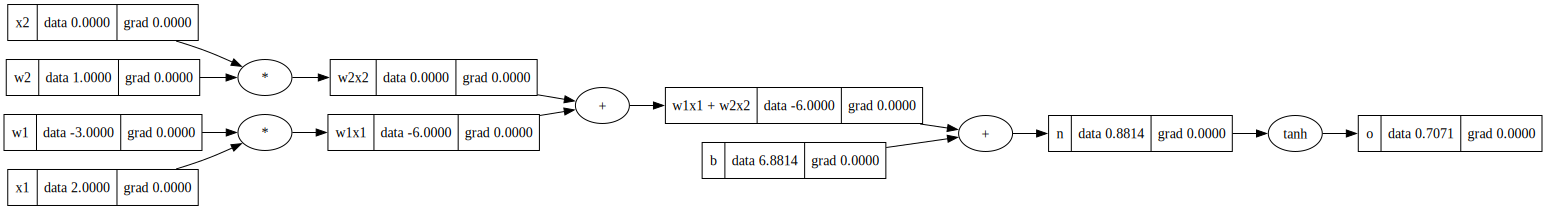

In [68]:
# Simple neurons can be represented by squash_func(x1w1 + x2w2 + b (bias))

# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.8813735870195432, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)


In [66]:
# derivative of tanh(x) = 1 - tanh(x)^2
o.grad = 1.0
n.grad = 1 - (o.data ** 2) # 1 - tanh(n)**2, but o = tanh(n)

# in addition, grad just flows from parent to child
b.grad = n.grad
w1x1w2x2.grad = n.grad

w1x1.grad = w1x1w2x2.grad
w2x2.grad = w1x1w2x2.grad


# mul + chain rule => other val * grad of parent
w1.grad = x1.data * w1x1.grad
x1.grad = w1.data * w1x1.grad

w2.grad = x2.data * w2x2.grad
x2.grad = w2.data * w2x2.grad

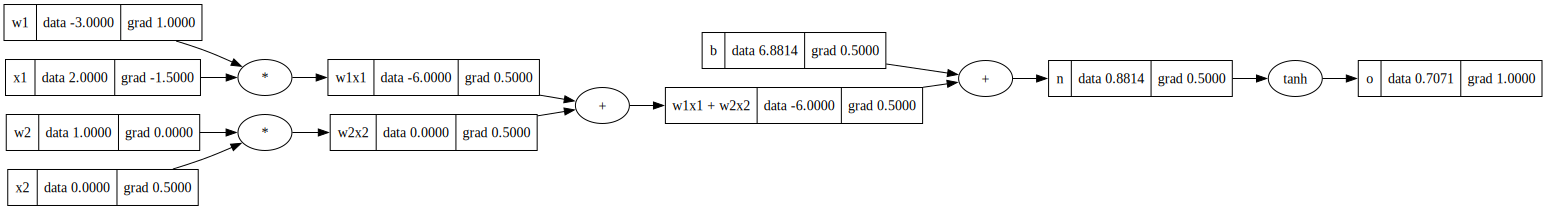

In [67]:
draw_dot(o)